In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

In [3]:
img1 = cv2.imread("/content/drive/MyDrive/VR/img1.png")
img2 = cv2.imread("/content/drive/MyDrive/VR/img2.png")
img3 = cv2.imread("/content/drive/MyDrive/VR/img3.png")

In [4]:
images = [img1,img2,img3]
n = len(images)

for i in range(n):
  while images[i].shape[0] > 512 or images[i].shape[1] > 512:
    images[i] = cv2.pyrDown(images[i])

In [5]:
for i in images:
  print(i.shape)

(315, 317, 3)
(315, 317, 3)
(315, 317, 3)


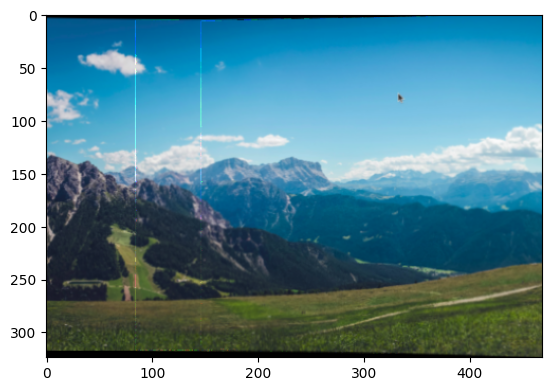

In [6]:
def FindMatches(BaseImage, SecImage):

    # Using SIFT to find the keypoints and decriptors in the images
    Sift = cv2.SIFT_create()
    BaseImage_kp, BaseImage_des = Sift.detectAndCompute(cv2.cvtColor(BaseImage, cv2.COLOR_BGR2GRAY), None)
    SecImage_kp, SecImage_des = Sift.detectAndCompute(cv2.cvtColor(SecImage, cv2.COLOR_BGR2GRAY), None)

    cv2.imwrite("BaseImage_kp.jpg", cv2.drawKeypoints(BaseImage, BaseImage_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    cv2.imwrite("SecImage_kp.jpg", cv2.drawKeypoints(BaseImage, BaseImage_kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))

    # Using Brute Force matcher to find matches.
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors
    Initialmatches = bf.match(BaseImage_des, SecImage_des)

    # Sort matches by distance
    GoodMatches = sorted(Initialmatches, key=lambda x: x.distance)
    GoodMatches = GoodMatches[:int(len(GoodMatches) * 0.75)]

    cv2.imwrite("Good_matches.jpg", cv2.drawMatches(BaseImage, BaseImage_kp, SecImage, SecImage_kp, GoodMatches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))

    return GoodMatches, BaseImage_kp, SecImage_kp


def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    BaseImage_pts = []
    SecImage_pts = []

    BaseImage_pts = np.float32([BaseImage_kp[m.queryIdx].pt for m in Matches])
    SecImage_pts = np.float32([SecImage_kp[m.trainIdx].pt for m in Matches])

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    # Finding the homography matrix(transformation matrix)
    (HomographyMatrix, Status) = cv2.findHomography(SecImage_pts, BaseImage_pts, cv2.RANSAC, 5.0)

    return HomographyMatrix, Status


def GetNewFrameSizeAndMatrix(HomographyMatrix, SecImageShape, BaseImageShape):
    Height, Width = SecImageShape

    # Define the four corners of the secondary image
    InitialCorners = np.array([[0, 0, 1], [Width - 1, 0, 1],
                                [Width - 1, Height - 1, 1], [0, Height - 1, 1]]).T

    # Apply homography to get transformed corner positions
    TransformedCorners = np.dot(HomographyMatrix, InitialCorners)
    TransformedCorners /= TransformedCorners[2]  # Normalize by the third coordinate

    x, y = TransformedCorners[:2]  # Extract x, y coordinates

    # Find new image size and correction offsets
    min_x, min_y = np.floor(x.min()).astype(int), np.floor(y.min()).astype(int)
    max_x, max_y = np.ceil(x.max()).astype(int), np.ceil(y.max()).astype(int)

    CorrectionX, CorrectionY = max(0, -min_x), max(0, -min_y)
    NewWidth = max_x + CorrectionX
    NewHeight = max_y + CorrectionY

    # Ensure at least the base image fits
    NewWidth = max(NewWidth, BaseImageShape[1] + CorrectionX)
    NewHeight = max(NewHeight, BaseImageShape[0] + CorrectionY)

    # Adjust homography to account for corrections
    OffsetMatrix = np.array([[1, 0, CorrectionX], [0, 1, CorrectionY], [0, 0, 1]])
    HomographyMatrix = np.dot(OffsetMatrix, HomographyMatrix)

    return [NewHeight, NewWidth], (CorrectionX, CorrectionY), HomographyMatrix


def feather_blend(img1, img2, mask):
    """Simple feather blending using a gradient mask."""
    img1 = img1.astype(np.float32)
    img2 = img2.astype(np.float32)
    mask = mask.astype(np.float32) / 255  # Normalize mask to range [0, 1]

    blended = img1 * (1 - mask) + img2 * mask
    return blended.astype(np.uint8)


def StitchImages(BaseImage, SecImage):
    # Applying Cylindrical projection on SecImage
    SecImage_Cyl, mask_x, mask_y = cylindrical_projection(SecImage,1100)

    # Getting SecImage Mask
    SecImage_Mask = np.zeros(SecImage_Cyl.shape, dtype=np.uint8)
    SecImage_Mask[mask_y, mask_x, :] = 255

    # Finding matches between the 2 images and their keypoints
    Matches, BaseImage_kp, SecImage_kp = FindMatches(BaseImage, SecImage_Cyl)

    # Finding homography matrix.
    HomographyMatrix, Status = FindHomography(Matches, BaseImage_kp, SecImage_kp)

    # Finding size of new frame of stitched images and updating the homography matrix
    NewFrameSize, Correction, HomographyMatrix = GetNewFrameSizeAndMatrix(HomographyMatrix, SecImage_Cyl.shape[:2], BaseImage.shape[:2])

    # Finally placing the images upon one another.
    SecImage_Transformed = cv2.warpPerspective(SecImage_Cyl, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    SecImage_Transformed_Mask = cv2.warpPerspective(SecImage_Mask, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))

    BaseImage_Transformed = np.zeros((NewFrameSize[0], NewFrameSize[1], 3), dtype=np.uint8)
    BaseImage_Transformed[Correction[1]:Correction[1]+BaseImage.shape[0], Correction[0]:Correction[0]+BaseImage.shape[1]] = BaseImage

    overlap = (SecImage_Transformed_Mask > 0) & (BaseImage_Transformed > 0)

    alpha = np.zeros_like(overlap, dtype=np.float32)
    alpha[overlap] = np.linspace(0, 1, np.sum(overlap))

    blended = (BaseImage_Transformed.astype(np.float32) * (1 - alpha) + SecImage_Transformed.astype(np.float32) * alpha).astype(np.uint8)

    StitchedImage = cv2.bitwise_or(SecImage_Transformed, cv2.bitwise_and(BaseImage_Transformed, cv2.bitwise_not(SecImage_Transformed_Mask)))

    return StitchedImage




def cylindrical_projection(img, f):

    # Extract image height and width
    h, w = img.shape[:2]
    # Camera matrix
    K = np.array([[f, 0, w//2], [0, f, h//2], [0, 0, 1]])

    #create empty maps
    map_x = np.zeros((h, w), dtype=np.float32)
    map_y = np.zeros((h, w), dtype=np.float32)


    # create new transformed co-ordinates
    ti_x, ti_y = [], []
    for y in range(h):
        for x in range(w):
            X = (x - w//2) / f
            Y = (y - h//2) / f
            Z = np.sqrt(X**2 + 1)

            new_x = f * np.arctan(X) + w//2
            new_y = f * Y / Z + h//2

            if 0 <= new_x < w and 0 <= new_y < h:
                map_x[y, x] = new_x
                map_y[y, x] = new_y
                ti_x.append(int(new_x))
                ti_y.append(int(new_y))

    #create a new transformed image and if pixels are missing interpolate using simple linear interpolation
    transformed_img = cv2.remap(img, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return transformed_img, np.array(ti_x), np.array(ti_y)


if __name__ == "__main__":
    Images = images
    BaseImage, _, _ = cylindrical_projection(Images[0],1100)

    for i in range(1, len(Images)):
        StitchedImage = StitchImages(BaseImage, Images[i])
        BaseImage = StitchedImage.copy()

    plt.imshow(cv2.cvtColor(BaseImage,cv2.COLOR_BGR2RGB))
    plt.show()